In [1]:
import tarfile
import pandas as pd
import glob
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

In [34]:
path = './my_folder/2019'
files = glob.glob(path + '/*.csv')

stations = []
tempes_of_stations = []

for filename in range(190):
    d = pd.read_csv(files[filename])
    stations.append(d.STATION[0])
    tempes_of_stations.append(list(d.TEMP[0:100]))



In [3]:
days = [f'D{i}' for i in range(1,101)]

In [35]:
df = pd.DataFrame(tempes_of_stations, index=stations, columns=days)
df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100
1001099999,24.0,36.2,35.5,35.8,35.8,28.1,23.5,24.0,36.7,22.2,...,25.2,21.6,24.5,32.6,31.6,26.0,28.9,30.9,32.1,33.2
1001499999,39.7,36.4,36.5,45.6,42.5,38.9,40.6,35.9,38.4,39.7,...,51.4,51.4,60.1,66.4,62.5,60.5,58.7,55.3,50.2,57.5
1002099999,-0.1,5.1,19.7,14.3,16.1,20.0,18.8,16.1,19.9,20.1,...,-0.7,4.1,10.3,12.1,18.2,14.0,9.3,5.9,21.3,14.5
1003099999,3.9,11.6,27.8,23.6,27.9,29.0,25.6,24.9,22.4,25.6,...,14.6,16.0,20.1,23.4,25.9,21.5,15.4,13.8,27.2,29.8
1006099999,5.2,4.3,14.2,16.0,18.8,18.9,21.2,16.5,21.6,22.0,...,4.8,5.0,7.9,12.7,22.2,14.2,13.5,8.3,20.0,20.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374099999,33.0,26.9,30.5,39.4,33.7,31.7,25.1,29.2,24.4,23.7,...,30.1,27.9,29.9,38.8,33.6,33.6,32.4,31.7,29.8,26.7
1375099999,25.5,21.6,30.0,36.1,34.1,32.8,23.6,22.9,21.0,26.5,...,24.4,22.9,28.3,34.6,28.7,29.1,25.8,22.4,20.8,18.8
1375599999,40.0,40.2,44.3,48.1,46.6,44.5,44.1,41.0,40.2,48.1,...,41.3,41.7,44.5,46.4,49.2,44.9,44.2,42.9,43.2,41.9
1376099999,40.6,31.9,28.4,42.1,29.0,26.1,25.9,35.2,29.5,23.1,...,33.9,36.2,33.9,43.3,39.7,40.0,39.2,39.3,35.4,34.8


In [31]:
def DMD(df, window):
    df1 = df[df.columns[:window-1]]
    df2 = df[df.columns[1:window]]

    X1 = df1.values
    X2 = df2.values


    U, S, Vh = linalg.svd(X1, full_matrices=False)
    r = min(np.linalg.matrix_rank(X1), U.shape[1])

    U_r = U[:, :r]
    S_r = np.diag(S[:r])
    V_r = Vh[:r, :]

    # A_tilde = np.dot(U.T, np.dot(Xt, np.dot(Vh.T, np.linalg.inv(sigma))))
    A_tilde = U_r.conj().T @ X2 @ V_r.conj().T @ np.linalg.inv(S_r) # Koopman Matrix

    eig_val, eig_vec = np.linalg.eig(A_tilde)

    # phi = (Xt @ Vh.T @ np.linalg.inv(sigma) @ eig_vec)

    phi = X2 @ V_r.conj().T @ np.linalg.inv(S_r) @ eig_vec # DMD modes

    # freq = np.log(eig_val)

    x1 = X1[:,0]
    b = np.linalg.pinv(phi) @ x1   # amplitudes

    return phi, eig_val, b
    


In [20]:
def predict(window, days, phi, freq, b):
    t1 = np.linspace(1,10,100)
    dt = t1[1]-t1[0]
    t_dyn = np.zeros((window-1,days))
    t = np.arange(0,days)*dt

    for iter in range(days):
        t_dyn[:, iter] = b * np.exp(freq * t[iter])

    x_dmd = np.dot(phi, t_dyn)
    return x_dmd

In [7]:
def rmse(org,pred, stations):
    out = []
    t = (org-pred.real)**2
    for i in range(190):
        x = np.mean(t.loc[stations[i]])
        out.append(np.sqrt(x))
    return out


In [105]:
window = int(input('enter window size = '))
phi, freq, b = DMD(df, window)


rmse for 1 day prediction

In [106]:
# days_want_to_predict = int(input('No.of days you want to predict = '))
days_want_to_predict = 1
org1 = df[df.columns[window:window+days_want_to_predict]]
pred = predict(window, days_want_to_predict, phi, freq, b)
pred1 = pred.real


np.mean(rmse(org1, pred1, stations))

C:\Users\rchar\AppData\Local\Temp\ipykernel_11560\3889421443.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, iter] = b * np.exp(freq * t[iter])


5.665342835838629

Text(0.5, 1.0, 'RMSE for Each Station')

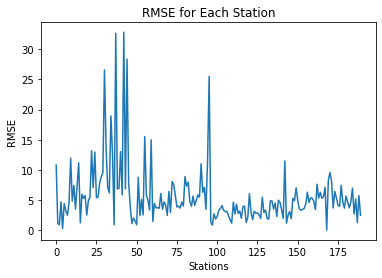

In [81]:
err1 = rmse(org1, pred1, stations)
plt.plot(err1)
plt.xlabel('Stations')
plt.ylabel('RMSE')
plt.title('RMSE for Each Station')

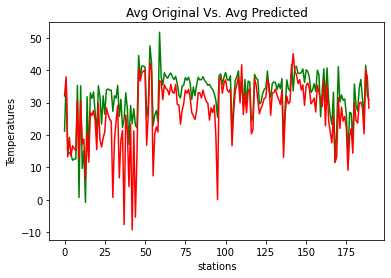

In [85]:
avg_org = [np.mean(org1.loc[stations[i]]) for i in range(190)]
avg_pred = [np.mean(pred1[i]) for i in range(190)]

plt.plot(avg_org, 'g')
plt.plot(avg_pred, 'r')
plt.xlabel('stations')
plt.ylabel('Temperatures')
plt.title('Avg Original Vs. Avg Predicted')
plt.show()

rmse for 3 day prediction


In [107]:
# days_want_to_predict = int(input('No.of days you want to predict = '))
days_want_to_predict = 3
org2 = df[df.columns[window:window+days_want_to_predict]]
pred = predict(window, days_want_to_predict, phi, freq, b)
pred2 = pred.real


np.mean(rmse(org2, pred2, stations))

C:\Users\rchar\AppData\Local\Temp\ipykernel_11560\3889421443.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, iter] = b * np.exp(freq * t[iter])


9.360379593019573

Text(0.5, 1.0, 'RMSE for Each Station')

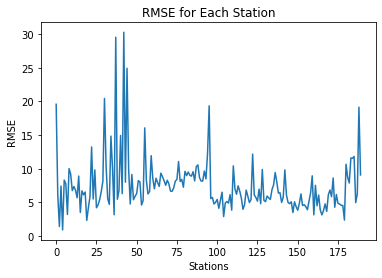

In [82]:
err2 = rmse(org2, pred2, stations)
plt.plot(err2)
plt.xlabel('Stations')
plt.ylabel('RMSE')
plt.title('RMSE for Each Station')

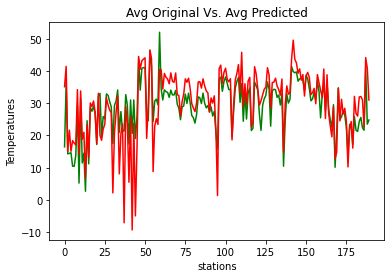

In [84]:
avg_org = [np.mean(org2.loc[stations[i]]) for i in range(190)]
avg_pred = [np.mean(pred2[i]) for i in range(190)]

plt.plot(avg_org, 'g')
plt.plot(avg_pred, 'r')
plt.xlabel('stations')
plt.ylabel('Temperatures')
plt.title('Avg Original Vs. Avg Predicted')
plt.show()

rmse for 5 day prediction


In [108]:
# days_want_to_predict = int(input('No.of days you want to predict = '))
days_want_to_predict = 5
org3 = df[df.columns[window:window+days_want_to_predict]]
pred = predict(window, days_want_to_predict, phi, freq, b)
pred3 = pred.real


np.mean(rmse(org3, pred3, stations))

C:\Users\rchar\AppData\Local\Temp\ipykernel_11560\3889421443.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, iter] = b * np.exp(freq * t[iter])


13.004502365818237

Text(0.5, 1.0, 'RMSE for Each Station')

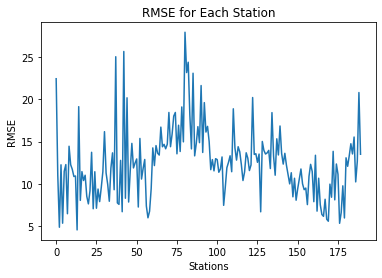

In [83]:
err3 = rmse(org3, pred3, stations)
plt.plot(err3)
plt.xlabel('Stations')
plt.ylabel('RMSE')
plt.title('RMSE for Each Station')

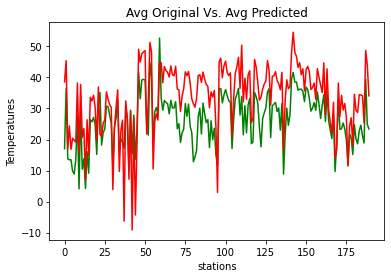

In [80]:
avg_org = [np.mean(org3.loc[stations[i]]) for i in range(190)]
avg_pred = [np.mean(pred3[i]) for i in range(190)]

plt.plot(avg_org, 'g')
plt.plot(avg_pred, 'r')
plt.xlabel('stations')
plt.ylabel('Temperatures')
plt.title('Avg Original Vs. Avg Predicted')
plt.show()

Text(0, 0.5, 'RMSE')

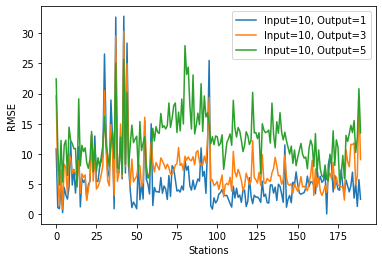

In [73]:
plt.plot(err1)
plt.plot(err2)
plt.plot(err3)
plt.legend([f'Input={window}, Output=1', f'Input={window}, Output=3', f'Input={window}, Output=5'])
plt.xlabel('Stations')
plt.ylabel('RMSE')